# VWAP

Hands-on exploration of basics behind a vwap order.

## Overview 

### VWAP Definition

$$P_{VWAP}= { \frac{ \sum _{{j}} { P_{j} \cdot Q_{j}}} {\sum _{j} {Q_{j}}}}$$

where:

$$ \displaystyle{P_{j}} \;is\; price \; of\; trade \;{j}$$
$$ \displaystyle{Q_{j}} \;is \;quantity \;of\; trade \;{j}$$

An ordinary VWAP order follows a schedule which is informed by historical volume curves and then adapts throughout its execution based on models which might include volume and volatility prediction, alpha signals and execution costs.

A reasonable first goal in writing a vwap algo is to do as little harm as possible: to get close to the VWAP price.  
To do that, we need the basics.  We need a historical volume curve which is partitioned 
across the 390 minutes of the typical equity trading day.  Likewise, we need an estimate for the 
expected volatility across those same periods.  With these in hand, we can construct a trading schedule 
with so called ‘uncertainty bands’ [“Design and Implementation of Schedule‐Based Trading Strategies 
Based on Uncertainty Bands”, Markov, Mazur, Saltz](https://arxiv.org/pdf/1409.1441v1.pdf)). 

## Data, vwap & ucurves  

In [19]:
# get dependencies
library(data.table)
library(lubridate)
library(PerformanceAnalytics)
library(futile.logger)
library(ggplot2)
library(TTR)

source('vwap.R')

Let's pull-in requisite data 

In [2]:
load(file='spy16.Rdata')
spydt <- as.data.table(spy16)
# set tz
attr(spydt$times, "tzone") <- 'America/New_York'
spydt$date <- as.Date(spydt$times)
setnames(spydt,'times','time')
setcolorder(spydt, c('date','time','value','size'))
spydt <- spydt[size>0]
setkey(spydt,date,time)

For this study, we assume all trading is to be done on the SPY.  We use tick data procured from 
Bloomberg via the Rblpapi api or for a detached impl like this, we can pull from a file.

Now that we have some data, let's generate some s-curves and plot them:

In [3]:
alldays <- sort(unique(spydt$date))
alldays <- head(alldays,length(alldays)-1)

#generate all scurves 
allscurves <- do.call('cbind',(lapply(alldays, scurve4day)))


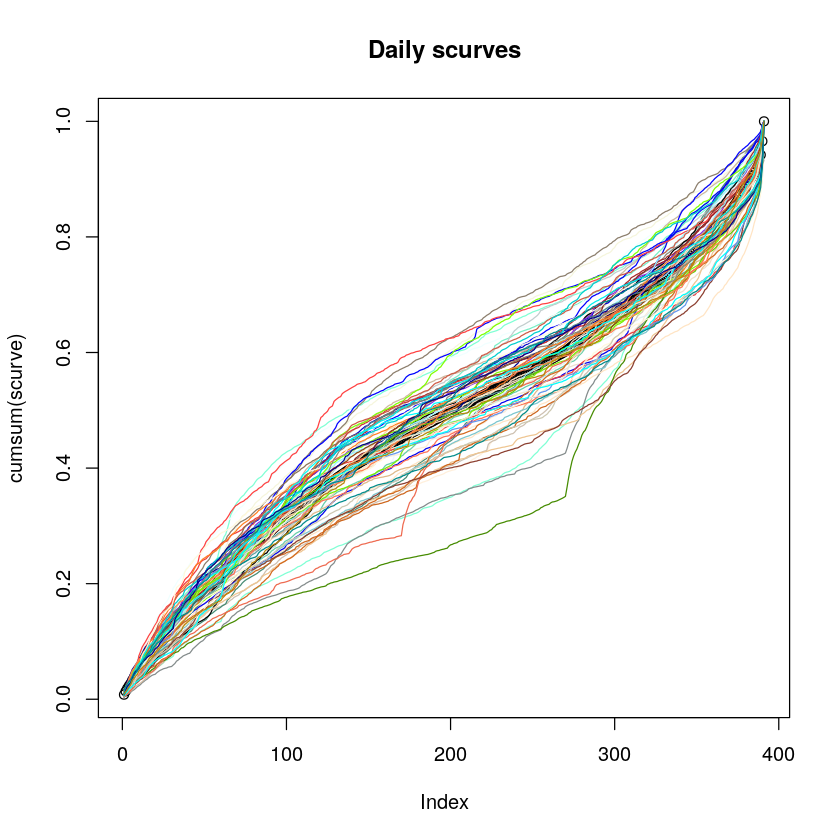

In [4]:
# plot all ucurves:
scurve <- apply(allscurves,1,mean)
plot(cumsum(scurve),type='b', main='Daily scurves')
noop <- lapply(1:ncol(allscurves),function(day) {
  lines(cumsum(allscurves[,day]),col=colors()[day])
})

Note the several kinks in the individual scurves where the daily volume far undershoots normal until a particular point which will likely coincide with a Fed grandee opining.  If this were a real implementation, we'd customize our scurves for such occasions just as we'd undoubtedly customize by name, for holidays (half days or days where the markets are open but volumes are known to be low) and perhaps other factors as well.

We can mash the scurves together and dub it 'typical'.  

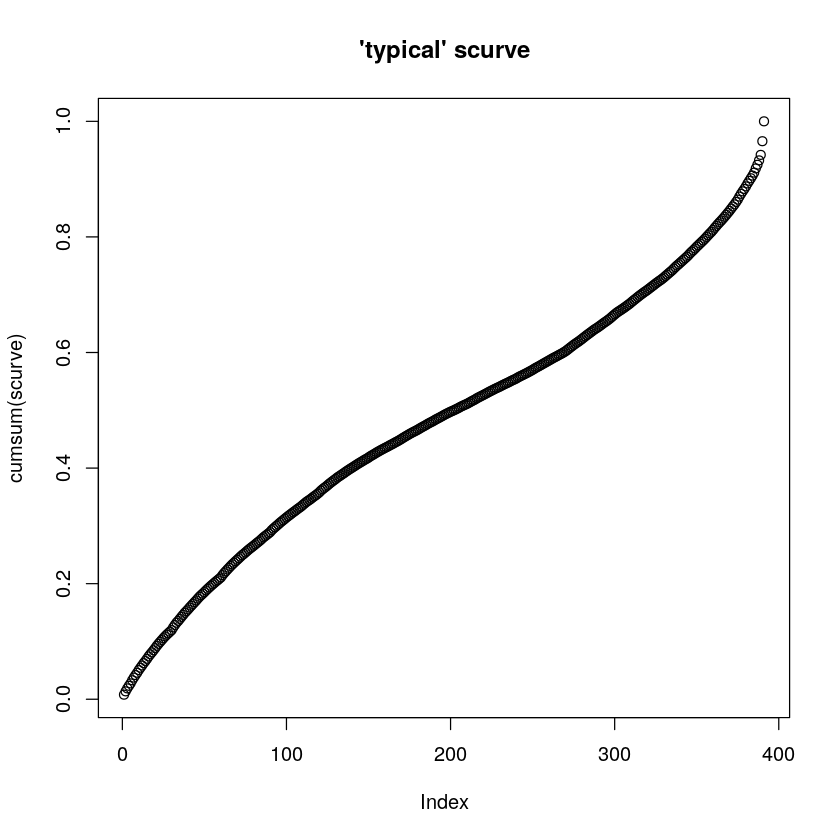

In [5]:
# and the median ucurve & scurve/tgt
tgt <- cumsum(scurve)
plot(cumsum(scurve),type='b', main="'typical' scurve")


## Volatility & Uncertainty Bands  

Let's incorporate volatility over the same periods, normalizing and smoothing: 

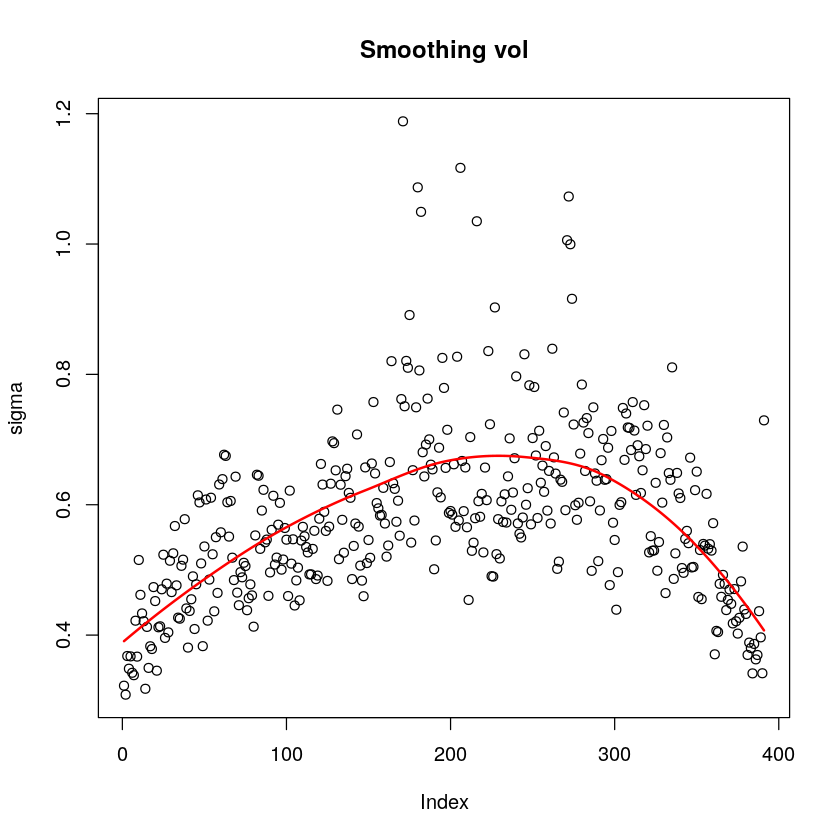

In [6]:
sigma <- apply(allscurves,1,function(x){sd(x)/mean(x)})
# too raw, let's smooth
x <- 1:length(sigma)
lo <- loess(sigma~x)
sigma.smoothd <- predict(lo)
plot(sigma,main='Smoothing vol')
lines(predict(lo),col='red',lwd='2')

With this, we can create our uncertainty bands along with a constant n which we choose to control how 
wide we allow those bands to be: 

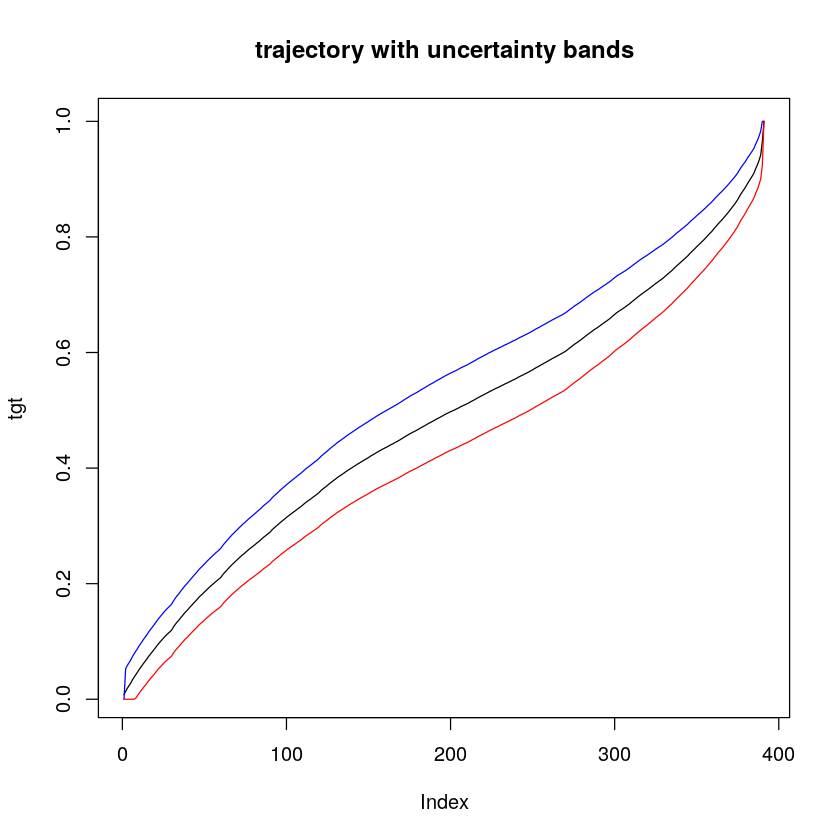

In [7]:
tgt <- cumsum(scurve)
n=10
mintgt <- pmax(0,(tgt - (n * sigma.smoothd )))
maxtgt <- pmin(1,( tgt + (n * sigma.smoothd)))

# now we can generate a baseline trajectoy
traj <- trading.trajectory(tgt,sigma.smoothd)


if our trading horizon doesn't cover the whole day, we need to rescale to segment the trajectory:

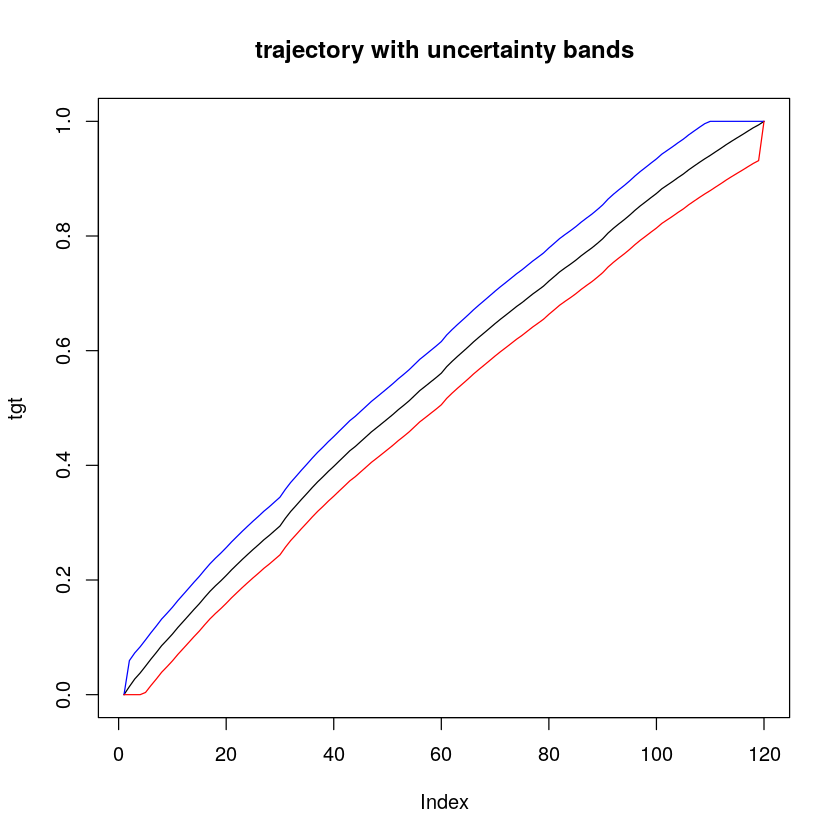

In [8]:
  # if we want a smaller trading horizon, we need to rescale
  unscaled <- tgt[31:150]
  tgt10noon <- (unscaled-min(unscaled))/(max(unscaled)-min(unscaled))
  ssigma10noon <- sigma.smoothd[31:150]
  # and then everything else is the same
  traj <- trading.trajectory(tgt10noon,ssigma10noon)

With these 'static' preliminaries in hand, one can write a trading strategy which uses the upper & lower bounds as guides for how aggressively it should be executing at any point in time.  eg, When above the standard trajectory it can be very opportunistic and presumably get good pricing.  As it approaches the lower bound, it needs to be aggressive and presumably incur greater costs.  Your models may vary.

A java prototype of such a thing (without the tactical awareness) is available here: https://github.com/hackthemarket/vwap/blob/master/SimpleVWAP.java


### VWAP Definition

$$P_{VWAP}= { \frac{ \sum _{{j}} { P_{j} \cdot Q_{j}}} {\sum _{j} {Q_{j}}}}$$

where:

$$ \displaystyle{P_{j}} \;is\; price \; of\; trade \;{j}$$
$$ \displaystyle{Q_{j}} \;is \;quantity \;of\; trade \;{j}$$


### Trading against the VWAP

Let's imagine a trading strategy comprised of two *parent* orders:

* **VWAP:**  3rd party VWAP execution of **x** shares of **XYZ**
* **Nostro:**  'Our' order: an order we will execute throughout the trading horizon of **-x** shares of **XYZ**

If we believe that we can generally beat the VWAP's performance (including costs), then we might decide to trade like this and the framework described above could well be used to do so.  

Let's examine the exposures we'd have if we allowed the Nostro order to complete before the VWAP order, eg, if the Nostro order had far out-performed the VWAP.

In particular, how do we hedge such an exposure?  Let's examine a case in detail.

In [9]:
# let's pick a day and calculate vwap for that day
day = '2016-04-20'
DT = spydt[date==day]
# add in cumvol
DT[,cumsize:=cumsum(size)]
# calc vwap
DT[,vwap:=value]
for (i in 2:nrow(DT))
    set(DT, i, 6L, ((DT$vwap[i-1]*DT$cumsize[i-1]) 
        + (DT$value[i]*DT$size[i]))/DT$cumsize[i])


date,time,value,size,cumsize
2016-04-20,2016-04-20 09:30:00,209.95,500,500
2016-04-20,2016-04-20 09:30:00,209.95,500,1000
2016-04-20,2016-04-20 09:30:00,209.96,254,1254
2016-04-20,2016-04-20 09:30:00,209.97,300,1554
2016-04-20,2016-04-20 09:30:00,209.97,100,1654
2016-04-20,2016-04-20 09:30:00,209.97,200,1854
2016-04-20,2016-04-20 09:30:00,209.96,2000,3854
2016-04-20,2016-04-20 09:30:00,209.96,2270,6124
2016-04-20,2016-04-20 09:30:00,209.96,500,6624
2016-04-20,2016-04-20 09:30:00,209.96,100,6724


date,time,value,size,cumsize,vwap
2016-04-20,2016-04-20 09:30:00,209.95,500,500,209.95
2016-04-20,2016-04-20 09:30:00,209.95,500,1000,209.95
2016-04-20,2016-04-20 09:30:00,209.96,254,1254,209.96
2016-04-20,2016-04-20 09:30:00,209.97,300,1554,209.97
2016-04-20,2016-04-20 09:30:00,209.97,100,1654,209.97
2016-04-20,2016-04-20 09:30:00,209.97,200,1854,209.97
2016-04-20,2016-04-20 09:30:00,209.96,2000,3854,209.96
2016-04-20,2016-04-20 09:30:00,209.96,2270,6124,209.96
2016-04-20,2016-04-20 09:30:00,209.96,500,6624,209.96
2016-04-20,2016-04-20 09:30:00,209.96,100,6724,209.96


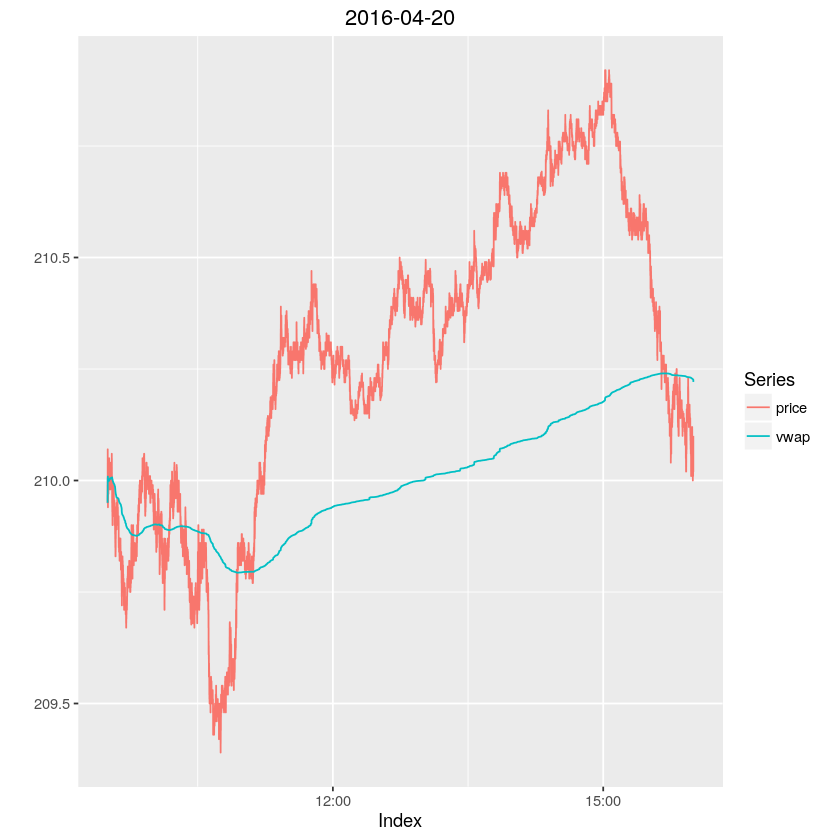

In [10]:
#let's plot
dts <- merge( price=xts(DT$value,order.by=DT$time), vwap=xts(DT$vwap,order.by=DT$time))
autoplot(dts,facets=NULL,main=day)


So, on this particular day we had the price run up and the vwap lagged before the price turned hard into the close.

If our Nostro order was short and our VWAP was long, we can imagine our return at 15:00 being quite robust and it might lead us to close-out the Nostro order entirely in an effort to maximize our gains.

If we had been using the 'typical' scurve from above to define our trajectory, then at 15:00, we would have completed about ~73% of the order, leaving a residual long exposure of ~27% of the order with an equivalent remainder of time before the close:

In [11]:
tgt[330]

[1] 0.7298666

Let's try to calculate our approximate pnl throughout the day assuming we simply execute in-line with our volume expectations.  To do this, we'll compress the day into minute long segments/bars and then execute the appropriate volume-based amount at the average price of each bar.

In [12]:
X <- DT
X$time <- X$cumsize <- X$date <- NULL
qDT <- xts( X, order.by=DT$time)
#autoplot(qDT,facets=NULL,main=day)
# now let's force timestamps to closest minute boundary... and repack in DF
qmDT <- align.time(qDT, 60)
DF <- as.data.frame(period.apply(qmDT, endpoints(qmDT, "minutes"), mean))

DF$time <- index(qDT[endpoints(qmDT, "minutes")])
rownames(DF) <- NULL # index(qDT[endpoints(qmDT, "minutes")])

# now let's add-in the tgt
DF$tgt <- tgt
# which is already cumulated so let's diff
DF$trd <- c (DF$tgt[1], diff(DF$tgt))

#DF

value,size,vwap,time,tgt,trd
209.9995,290.6034,209.9932,2016-04-20 09:30:59,0.007936842,0.007936842
210.0135,235.0356,210.0033,2016-04-20 09:31:59,0.013675642,0.005738800
210.0146,262.5697,210.0059,2016-04-20 09:32:59,0.018807234,0.005131592
209.9445,255.4794,210.0007,2016-04-20 09:33:59,0.023277952,0.004470718
209.9341,261.9197,209.9904,2016-04-20 09:34:59,0.027468449,0.004190497
209.8875,245.3435,209.9709,2016-04-20 09:35:59,0.032859750,0.005391301
209.9290,178.9645,209.9610,2016-04-20 09:36:59,0.037480653,0.004620902
209.8702,228.1888,209.9555,2016-04-20 09:37:59,0.041820709,0.004340057
209.8366,182.5012,209.9469,2016-04-20 09:38:59,0.045828782,0.004008072
209.7807,232.5143,209.9331,2016-04-20 09:39:59,0.050464731,0.004635949


'data.frame':	391 obs. of  8 variables:
 $ value : num  210 210 210 210 210 ...
 $ size  : num  291 235 263 255 262 ...
 $ vwap  : num  210 210 210 210 210 ...
 $ time  : POSIXct, format: "2016-04-20 09:30:59" "2016-04-20 09:31:59" ...
 $ tgt   : num  0.00794 0.01368 0.01881 0.02328 0.02747 ...
 $ trd   : num  0.00794 0.00574 0.00513 0.00447 0.00419 ...
 $ nostro: num  210 210 210 210 210 ...
 $ pnl   : num  0.00623 0.00826 0.01024 0.0052 0.00113 ...


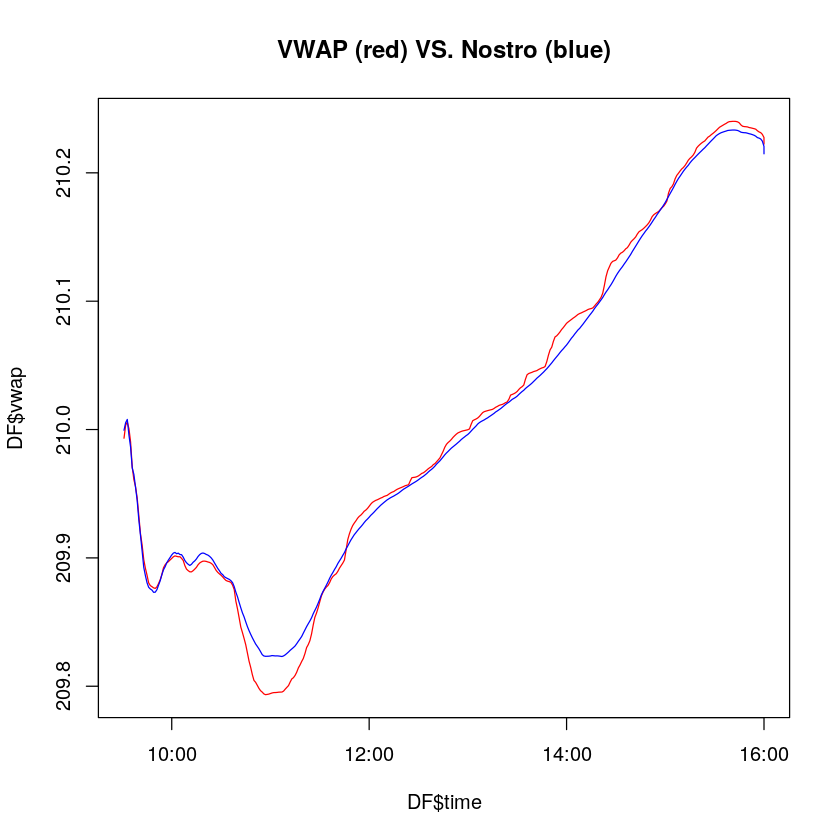

In [13]:
# let's calculate our expected price (assuming no model!)
DF$nostro <- DF$value
for (i in 2:nrow(DF))
    DF$nostro[i] <- ((DF$nostro[i-1]*DF$tgt[i-1]) + (DF$nostro[i]*DF$trd[i]))/DF$tgt[i]

# and finally the 'pnl'
DF$pnl <- cumsum(DF$nostro - DF$vwap)

plot(DF$time,DF$vwap, type='l', col='red', main='VWAP (red) VS. Nostro (blue)')
lines(DF$time,DF$nostro, type='l', col='blue')
#lines(DF$time,DF$pnl+209.8, type='l', col='green')
str(DF)


So, our efforts above to track the vwap prove fruitful: we can get quite close even with a reasonably crude approach.
The pnl is tiny and appears to track market moves:

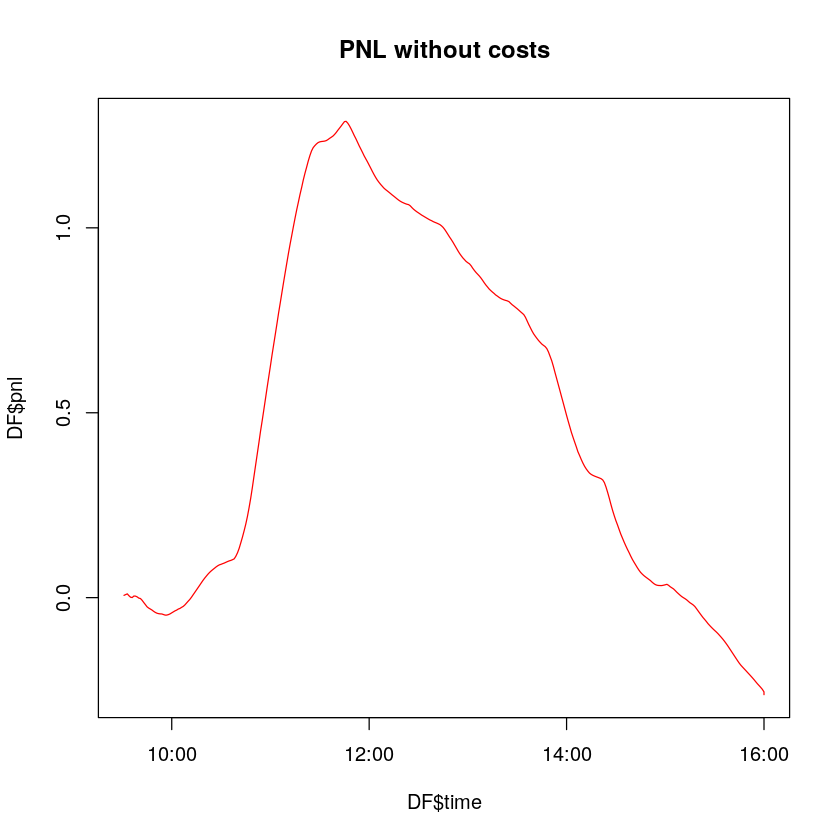

In [14]:
plot(DF$time,DF$pnl, type='l', col='red', main='PNL without costs')


This is a good finding.  It means that we can 'do limited harm' even in the face of aggressive market moves.  But it leaves open the question of the underlying alpha model.  

Just for completeness, let's take a quick look at how this might behave if we were to trade out of the Nostro order at 15:00.

In [15]:
# let's save our old DF and then use it
all_day_DF <- DF
#DF[ index(DF) > 320 & index(DF) < 360, ]
exectm <- 330
DF[ index(DF) == exectm, ]


,value,size,vwap,time,tgt,trd,nostro,pnl
330,210.8359,255.1695,210.1758,2016-04-20 14:59:59,0.7298666,0.002258112,210.1769,0.03480345


In [16]:
# if we trade at ~15:00, we can calculate our total nostro price
complete <- DF$tgt[exectm]
remain <- 1 - complete
lastpx <- DF$value[exectm]
nostropx <- ( (lastpx * remain) + (complete *  DF$nostro[exectm])) 
nostropx

[1] 210.3549

In [17]:
# the difference between this and our final vwap should be 
#   our pnl without costs
tail(DF)

pnl <- nostropx - DF$vwap[391] 
pnl

,value,size,vwap,time,tgt,trd,nostro,pnl
386,210.0911,224.3365,210.2328,2016-04-20 15:55:59,0.9185331,0.007252339,210.2275,-0.2327609
387,210.1687,230.0555,210.2319,2016-04-20 15:56:59,0.9248545,0.006321314,210.2271,-0.2375958
388,210.1457,226.5025,210.2313,2016-04-20 15:57:59,0.9324500,0.007595560,210.2264,-0.2425306
389,210.0603,267.5743,210.2300,2016-04-20 15:58:59,0.9419375,0.009487450,210.2247,-0.2478093
390,210.0566,292.9722,210.2275,2016-04-20 15:59:59,0.9656095,0.023672069,210.2206,-0.2547206
391,210.0526,64957.4444,210.2224,2016-04-20 16:00:00,1.0000000,0.034390461,210.2148,-0.2623177


[1] 0.1324948

So, not surprisingly, the trade does very well as it's effectively betting that it is the high of the day which in this cooked example it turns out to be.

What have we learned?  

The model matters.  

That is, this example shows a model-free environment in which we simply assume we can trade near the average price each minute.  This is probably true and thus we can likely expect to be able to trade near vwap (though we'll have to pay costs).  But until we diverge from that path, we have limited expected deviation from the vwap price.  

So, a case like the one above where we trade at the vwap throughout the day and then decide to make a big trade before the close is effectively a damped directional trade with a size of the untraded residual.

In what sense is it damped? 

Let's look at our actual residuals at 330 / 15:00


In [18]:
print('open:')
DF[ index(DF)==1,]
print(paste('trade time - ',DF$time[exectm],':',sep=''))
DF[ index(DF) == exectm, ]
print('close:')
DF[ index(DF)==max(index(DF)),]



[1] "open:"


value,size,vwap,time,tgt,trd,nostro,pnl
209.9995,290.6034,209.9932,2016-04-20 09:30:59,0.007936842,0.007936842,209.9995,0.006229473


[1] "trade time - 2016-04-20 14:59:59:"


,value,size,vwap,time,tgt,trd,nostro,pnl
330,210.8359,255.1695,210.1758,2016-04-20 14:59:59,0.7298666,0.002258112,210.1769,0.03480345


[1] "close:"


,value,size,vwap,time,tgt,trd,nostro,pnl
391,210.0526,64957.44,210.2224,2016-04-20 16:00:00,1,0.03439046,210.2148,-0.2623177


The current price is 210.8359 and both the vwap and nostro prices are down at 210.17ish.  So, there'a a big differential which smells of some opportunity.

The residual we have is interesting itself.  We have sold 100% of our sell order, but only bought 73% of our buy order meaning that we have a naturally decaying short position.  

The vwap is quite unlikely to move dramatically before the end of the day as it has already, volume-wise, expended most of its largesse.  To get an equivalent move back to it's origin would, I believe, require something like 4 or 5 times the ordinary expected volume and *a commensurate expansion of volatility*.

Effectively, we've sold volatility.

This implies that an entire portfolio of such residuals could likely be neutralized quite effectively with a small amount of volatility exposure if desired.


### [a technical comment on this document]

This document is implemented in a jupyter notebook powered by R via this genius bit of software here: https://github.com/IRkernel/IRkernel.  Thanks to the authors for such a great piece of code.